#### ASTR 3890 - Selected Topics: Data Science for Large Astronomical Surveys (Spring 2022)
***N. Hernitschek***
___

# Homework 8
### Due: Monday, Mar 28th at 11.00am CST

The completed lecture notebook must also be submitted by 11:00am Central Time on March 28th.

---

## Problem 1

**Phased LINEAR light curves**


Using the code snipplet below, load LINEAR light curves.


Extend the code to:

a) plot the light curves

b) compute the best period using a Fourier transformation

c) plot the phased data and best-fit curves.

d) Solve the problem by using Lomb-Scargle Periodograms.


In [52]:
from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

from astroML.utils.decorators import pickle_results
from astroML.time_series import search_frequencies, lomb_scargle, MultiTermFit
from astroML.datasets import fetch_LINEAR_sample

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)
import matplotlib
matplotlib.rc('_internal', classic_mode=True)

#------------------------------------------------------------
# Load the dataset
data = fetch_LINEAR_sample()
ids = [14752041, 1009459, 10022663, 10025796, 11375941, 18525697]


#------------------------------------------------------------
# Compute the best frequencies
@pickle_results('LINEAR_LS.pkl')
def compute_best_frequencies(ids, n_eval=10000, n_retry=5, generalized=True):
    results = {}
    for i in ids:
        t, y, dy = data[i].T
        print(" - computing power for {0} ({1} points)".format(i, len(t)))
        kwargs = dict(generalized=generalized)
        omega, power = search_frequencies(t, y, dy, n_eval=n_eval,
                                          n_retry=n_retry,
                                          LS_kwargs=kwargs)
        results[i] = [omega, power]

    return results

results = compute_best_frequencies(ids, n_eval=10000, n_retry=5)

@pickle_results: using precomputed results from 'LINEAR_LS.pkl'


### Solution

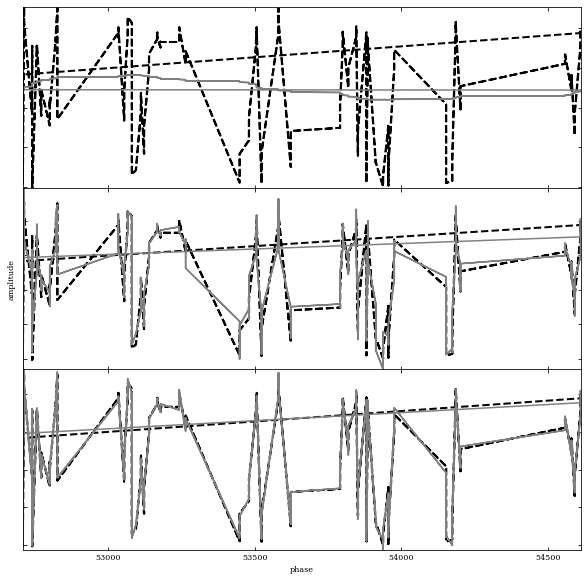

In [51]:
x = t

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0)

kvals = [1, 50, 100] # number of modes/frequencies in Fourier transform
subplots = [311, 312, 313]

for (k, subplot) in zip(kvals, subplots):
    ax = fig.add_subplot(subplot)

    # Use FFT to fit a truncated Fourier series
    y_fft = np.fft.fft(y) # fourier transform data
    y_fft[k + 1:-k] = 0 # truncate to only include frequencies you want
    y_fit = np.fft.ifft(y_fft).real # inverse transform to see time-domain model

    # plot the true value and the k-term reconstruction
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y, y]), '--k', lw=2)
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y_fit, y_fit]), color='gray')

    label = "%i mode" % k
    if k > 1:
        label += 's'

    if subplot == subplots[-1]:
        ax.set_xlabel('phase')
    else:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    if subplot == subplots[1]:
        ax.set_ylabel('amplitude')
    ax.yaxis.set_major_formatter(plt.NullFormatter())

plt.show()

When number of modes reaches 100, fourier transformation gets better.

        Use astropy.stats.LombScargle instead. [warnings]
        Use astropy.stats.LombScargle.false_alarm_probability instead. [warnings]
        Use astropy.stats.LombScargle instead. [astroML.time_series.periodogram]


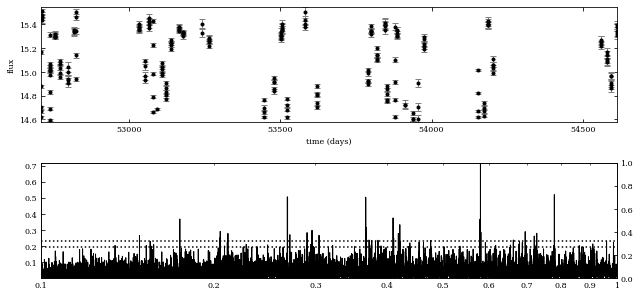

In [56]:
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap

# Compute periodogram
period = 10 ** np.linspace(-1, 0, 10000)
omega = 2 * np.pi / period
PS = lomb_scargle(t, y, dy, 
                  omega, generalized=True)

#------------------------------------------------------------
# Get significance via bootstrap
D = lomb_scargle_bootstrap(t, y, dy, omega, generalized=True, 
                           N_bootstraps=1000, random_state=0)
#Need to switch to this in the future
#D = LombScargle(t, y, dy, omega, generalized=True, 
#                N_bootstraps=1000, random_state=0)
sig1, sig5 = np.percentile(D, [99, 99.9])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.1, right=0.9, hspace=0.35)

# First panel: the data
ax = fig.add_subplot(211)
ax.errorbar(t, y, dy, fmt='.k', lw=1, ecolor='gray')
ax.set_xlabel('time (days)')
ax.set_ylabel('flux')

# Second panel: the periodogram & significance levels
ax1 = fig.add_subplot(212, xscale='log')
ax1.plot(period, PS, '-', 
         c='black', lw=1, zorder=1)
ax1.plot([period[0], period[-1]], 
         [sig1, sig1], ':', c='black')
ax1.plot([period[0], period[-1]], 
         [sig5, sig5], ':', c='black')

# Twin axis: label BIC on the right side
ax2 = ax1.twinx()

ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_minor_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_major_locator(plt.LogLocator(10))
ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3g'))

plt.show()